# How to detect peaks
This notebook demonstrates a quick way of finding and plotting peaks in data.


In [1]:
# First, the usual needs:

import random
from itertools import accumulate

import matplotlib as mpl
import matplotlib.pyplot as plt

import ipywidgets as widget

import hierarchical_peaks as hip

%matplotlib inline
plt.style.use('seaborn-talk')


We will use an example data set:

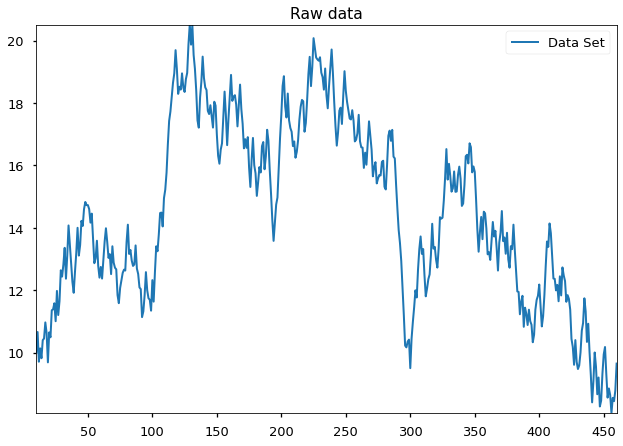

In [2]:
random.seed(a="It's...") # ref. Monty Python

# Generate a synthetic data set (X, Y):

X, Y = zip(*enumerate(accumulate((random.uniform(-1, 1) for n in range(450)), initial=10), start=10))


# plot to show the peaks that we are up against:

fig, ax = plt.subplots()
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.set_title("Raw data")
ax.plot(X, Y, lw=2, c="C0", label="Data Set")
ax.legend();

How do we detect peaks in this graph? We first make a tree out of our data set:

In [3]:
# Initialize a PeakTree object for the (X, Y) data set:

tree = hip.PeakTree(hip.filter_local_extrema(zip(X, Y)))

The `tree` object has a method for finding peaks called `maxdeep()`:

In [4]:
peaks = sorted(tree.maxdeep())

print(peaks)

[12, 20, 24, 26, 39, 79, 95, 100, 103, 107, 120, 147, 171, 178, 184, 209, 218, 257, 266, 273, 277, 285, 299, 304, 309, 318, 324, 356, 361, 365, 377, 387, 391, 400, 421, 428, 437, 445, 453, 458]


In this `peaks` list, each peak is represented by its key in the `tree`. How can we visualize them?

First, we must extend the `tree` with an extra attribute:

In [5]:
# Bestow the tree with an attribute containing location intervals:

tree.location = hip.peak_locations([(x, tree.elevation[x]) for x in tree], zip(X, Y))

We will highlight each of the detected `peaks` by drawing a nice, red **bounding box** around it.

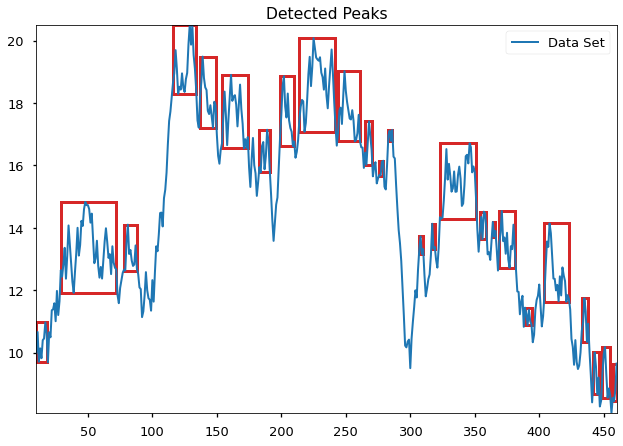

In [6]:
# Prepare a plot
fig, ax = plt.subplots()
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.set_title("Detected Peaks")

for peak in peaks:
    x1, x2 = tree.location[peak]
    y = tree.height(peak) - tree.depth(peak)
    # add a red bounding box:
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, y),
                                       width=x2 - x1,
                                       height=tree.depth(peak),
                                       fill=False,
                                       linewidth=3,
                                       edgecolor="C3",
                                      ))

# And plot the data set in blue:
ax.plot(X, Y, lw=2, c="C0", label="Data Set")
ax.legend();

So, we have managed to detect and plot the peaks!

As one can perhaps find by inspecting in the plotting code: The width of each bounding box is the width of the peak's `location` interval. And the height of each bounding box is the peak's `depth`.

## The parameter D_max

What `maxdeep()` does internally is to find all nodes `x` in the `tree` for which:
- The depth of `x` is below `D_max`
- The depth of the successor of `x `is above `D_max`

`D_max` is a constant value, which by default is 3.0.

So the same list of `peaks` as was found by `maxdeep()` could have been found by:

In [7]:
D_max = 3.0

print([x for x in tree if tree.depth(x) < D_max and tree.depth(tree.successor(x)) >= D_max])

[12, 20, 24, 26, 39, 79, 95, 100, 103, 107, 120, 147, 171, 178, 184, 209, 218, 257, 266, 273, 277, 285, 299, 304, 309, 318, 324, 356, 361, 365, 377, 387, 391, 400, 421, 428, 437, 445, 453, 458]


`maxdeep()` takes the `D_max` value as an argument. The `D_max` parameter controls the size of peaks. This can be explored in an interactive plot, in which we see the effect of changing the value of `D_max`.

Let us have bounding boxes and some more cool elements in the plot:

In [8]:
# plotting functions to show one peak:

def add_bounding_box(ax, x1, x2, height, depth):
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, height - depth),
                                       width= x2 - x1,
                                       height=depth,
                                       fill=False,
                                       linewidth=3,
                                       edgecolor="C3",
                                      ))    

def add_pedestal(ax, x1, x2, height, depth):
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, 0),
                                       width=x2 - x1,
                                       height=height - depth,
                                       fill=True,
                                       linewidth=1,
                                       edgecolor="C2",
                                       facecolor="lavender",
                                      ))

def add_crown(ax, xslice, yslice, baseline):
    ax.fill_between(xslice, yslice, baseline,
                    facecolor='gold',
                    alpha=0.9,
                   )

In [9]:
# Matplotlib´s fill_between requires that we prepare slices of our (X, Y) data set:

Xslice = {x: X[X.index(x1): X.index(x2)+1]  for x, (x1, x2) in tree.location.items()}
Yslice = {x: Y[X.index(x1): X.index(x2)+1]  for x, (x1, x2) in tree.location.items()}

In [10]:
def find_and_plot_peaks(D_max):
    
    # find peaks for given D_max value:
    peaks = tree.maxdeep(D_max)

    # make a new plot:
    fig, ax = plt.subplots()
    ax.set_xlim([min(X),max(X)])
    ax.set_ylim([min(Y),max(Y)])
    ax.set_title("Interactive plot")

    for peak in peaks:
        add_crown(ax, Xslice[peak], Yslice[peak], tree.height(peak) - tree.depth(peak))
        add_pedestal(ax, *tree.location[peak], tree.height(peak), tree.depth(peak))
        add_bounding_box(ax, *tree.location[peak], tree.height(peak), tree.depth(peak))

    
    ax.plot(X, Y, lw=2, c="C0", label="Data Set")
    ax.legend();

    

widget.interact(find_and_plot_peaks,
                D_max=widget.FloatSlider(min=0,
                                         max=max(Y)-min(Y),
                                         step=0.1,
                                         value=3.0,
                                         continuous_update=False
                                        )
               );

# Now use the slider to change the D_max parameter:

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='D_max', max=12.449776443279…

By increasing the depths with the slider, the peaks become wider and they merge into even larger peaks.

Note: A 'peak' in English sometimes means a point-like local maximum. 
But in the `hierarchical_peaks` software, a peak is rather a cluster with one or more local maxima.

Are you interested in the local maxima? `PeakTree` objects also have a method for that: `maxima()`. However, with `D_max=0` the resulting peaks shrink down to become equal to the local maxima.

In [11]:
# Verify that zero-depth peaks are actually local maxima: 

sorted(tree.maxdeep(0)) == sorted(tree.maxima())

True

To summarize, the analysis follows these steps:
1. Initialize a PeakTree instance `tree` by feeding data to `hip.PeakTree`
2. Find the location intervals using `hip.peak_locations`
3. Choose a value of `D_max`, which is an upper bound for the depths of peaks
4. Find a list of `peaks` using `tree.maxdeep(D_max)`
5. Plot ad libitum